
# 🌼 제너레이티브AI의 이해 - 2차시(24.11.19)

---


## 1. GAN
- 생성자와 판별자 두 가지 모델이 서로 경쟁하며 학습하는 방식
- 생성자 : 랜덤한 잠재 벡터를 입력받아, 이를 기반으로 새로운 데이터 생성
- 판별자 : 생성된 데이터가 진짜인지 가짜인지 판별

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [87]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])
# 음수와 양수 값을 모두 다룰 수 있기 때문에 데이터 다루기에 용이
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [88]:
example_data, example_label = next(iter(data_loader))

In [89]:
# sample = [1,2,3]
# sample_iter = iter(sample)
# next(sample_iter)

In [90]:
print(f'첫번째 데이터의 shape : {example_data.shape}')
# 배치 크기, 채널, 높이, 너비

첫번째 데이터의 shape : torch.Size([64, 1, 28, 28])


In [91]:
print(f'첫번째 데이터의 라벨 : {example_label[0]}')

첫번째 데이터의 라벨 : 7


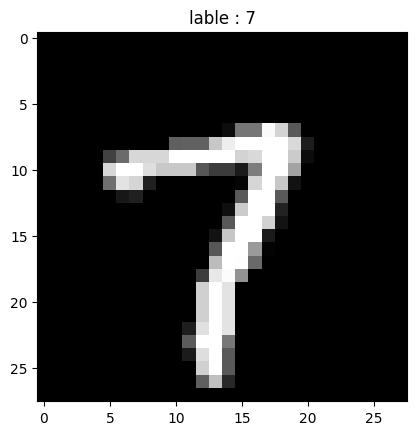

In [92]:
plt.imshow(example_data[0].squeeze(),cmap='gray')
plt.title(f'lable : {example_label[0].item()}')
plt.show()

In [93]:
input_size = 100
hidden_size_gen1 = 256
hidden_size_gen2 = 512
hidden_size_gen3 = 1024
output_size = 28 * 28

In [94]:
# 생성자 레이어 정의
gen_w1 = nn.Parameter(torch.randn(input_size, hidden_size_gen1) * 0.02)
# 첫번째 가중치 : input_size -> hiddin_size_gen1으로 변환하는 첫번째 레이어의 가중치를 랜덤으로 초기화
# 0.02는 가중치 값을 초기화 할때 스케일 조정
gen_b1 = nn.Parameter(torch.zeros(hidden_size_gen1))


gen_w2 = nn.Parameter(torch.randn(hidden_size_gen1, hidden_size_gen2) * 0.02)
gen_b2 = nn.Parameter(torch.zeros(hidden_size_gen2))

gen_w3 = nn.Parameter(torch.randn(hidden_size_gen2, hidden_size_gen3) * 0.02)
gen_b3 = nn.Parameter(torch.zeros(hidden_size_gen3))

gen_w4 = nn.Parameter(torch.randn(hidden_size_gen3, output_size) * 0.02)
gen_b4 = nn.Parameter(torch.zeros(output_size))

In [95]:
def generator(x):
    x = torch.matmul(x, gen_w1) + gen_b1
    # 입력 벡터 x에 첫번째 레이어의 가중치인 gen_w1을 곱하고 편향 gen_b1을 더하기
    # 첫번째 레이어의 출력
    x = torch.relu(x)

    x = torch.matmul(x, gen_w2) + gen_b2
    x = torch.relu(x)

    x = torch.matmul(x, gen_w3) + gen_b3
    x = torch.relu(x)

    x = torch.matmul(x, gen_w4) + gen_b4
    x = torch.tanh(x)
    # 마지막 출력을 -1~1사이 범위로 조정
    return x



In [96]:
# 판별자 정의
input_size_dis = 28 * 28
hidden_size_dis1 = 1024
hidden_size_dis2 = 512
hidden_size_dis3 = 256
output_size_dis = 1 # sigmoid 함수

In [97]:
dis_w1 = nn.Parameter(torch.randn(input_size_dis, hidden_size_dis1)*0.02)
dis_b1 = nn.Parameter(torch.zeros(hidden_size_dis1))

dis_w2 = nn.Parameter(torch.randn(hidden_size_dis1, hidden_size_dis2)*0.02)
dis_b2 = nn.Parameter(torch.zeros(hidden_size_dis2))

dis_w3 = nn.Parameter(torch.randn(hidden_size_dis2, hidden_size_dis3)*0.02)
dis_b3 = nn.Parameter(torch.zeros(hidden_size_dis3))

dis_w4 = nn.Parameter(torch.randn(hidden_size_dis3, output_size_dis)*0.02)
dis_b4 = nn.Parameter(torch.zeros(output_size_dis))

In [98]:
# 판별자 전방 전달
def discriminator(x):
    x = torch.matmul(x, dis_w1) + dis_b1
    x = F.leaky_relu(x, 0.2)
    # 0.2 : 음수 구간의 기울기에 곱해줄 작은 값
    x = torch.matmul(x, dis_w2) + dis_b2
    x = F.leaky_relu(x, 0.2)

    x = torch.matmul(x, dis_w3) + dis_b3
    x = F.leaky_relu(x, 0.2)

    x = torch.matmul(x, dis_w4) + dis_b4
    return torch.sigmoid(x)
# 출력이 0~1사이 값, 진짜 or 가짜

In [99]:
loss_fn = nn.BCELoss()
lr = 0.0002
gen_params = [gen_w1, gen_b1, gen_w2, gen_b2, gen_w3, gen_b3, gen_w4, gen_b4 ]
dis_params = [dis_w1, dis_b1, dis_w2, dis_b2, dis_w3, dis_b3, dis_w4, dis_b4 ]

In [100]:
optimizer_gen = torch.optim.Adam(gen_params, lr=lr)
optimizer_dis = torch.optim.Adam(dis_params, lr=lr)

In [101]:
# 위조지폐를 만들어서 판별자 학습
epochs = 20
for epoch in range(epochs):
    for real_images, _ in data_loader:
        batch_size = real_images.size(0)
        # real_images의 첫번째 차원의 값인 batch_size = 64
        real_images = real_images.view(batch_size, -1)
        # 기존에 (64, 1, 28, 28) -> (64, 784)
        
        real_labels = torch.ones(batch_size, 1)
        # (64, 1) 텐서를 생성해서 전체 요소의 각 값들이 전부 1 (진짜)
        fake_labels = torch.zeros(batch_size, 1)
        # (64, 1) 텐서를 생성해서 전체 요소의 각 값들이 전부 1 (가짜)

        # 생성자 학습 구간
        random_noise = torch.randn(batch_size, input_size)
        fake_images = generator(random_noise)

        # 판별자 학습 구간
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images)

        loss_real = loss_fn(real_output, real_labels)
        # 실제 이미지에 대한 손실값
        loss_fake = loss_fn(fake_output, fake_labels)
        # 가짜 이미지에 대한 손실값
        loss_dis = loss_real + loss_fake
        #판별자의 총 손실

        optimizer_dis.zero_grad()
        # 기울기 계산 전 가중치 초기하
        loss_dis.backward()
        # 역전파를 통한 기울기 계산
        optimizer_dis.step()
        # 기울기 업데이트

        # 생성자가 학습
        random_noise = torch.randn(batch_size, input_size)
        # 랜덤 노이즈 생성
        fake_images = generator(random_noise)
        fake_output = discriminator(fake_images)

        # 생성자 손실 계산 + 가중치 업데이트
        loss_gen = loss_fn(fake_output, real_labels)
        # fake_ouput : 생성자가 만든 가짜 이미지를 판별자가 판별한 결과
        # real_labels : 진짜 이미지의 라벨
        # 가짜 이미지의 판별 결과 vs 진짜 이미지의 라벨
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
    print(f'Epoch : {epoch + 1} / {epochs}, Loss D : {loss_dis.item()}, Loss G : {loss_gen.item()}')
    # 판별자 손실이 작은 경우 : 모든 가짜를 완벽하게 구분하고 있다는 의미
    # 생성자 손실이 큰 경우 : 판별자를 속이기 위한 진전이 없다는 의미


Epoch : 1 / 20, Loss D : 0.20709170401096344, Loss G : 3.452350616455078
Epoch : 2 / 20, Loss D : 0.11044330894947052, Loss G : 18.67170524597168
Epoch : 3 / 20, Loss D : 0.8051546216011047, Loss G : 3.2176034450531006
Epoch : 4 / 20, Loss D : 0.15765070915222168, Loss G : 3.4986956119537354
Epoch : 5 / 20, Loss D : 0.09439434856176376, Loss G : 6.31446647644043
Epoch : 6 / 20, Loss D : 0.6801379919052124, Loss G : 3.818540096282959
Epoch : 7 / 20, Loss D : 0.18905510008335114, Loss G : 8.88241958618164
Epoch : 8 / 20, Loss D : 0.149032324552536, Loss G : 3.8582684993743896
Epoch : 9 / 20, Loss D : 0.46232444047927856, Loss G : 3.6481549739837646
Epoch : 10 / 20, Loss D : 0.10247398912906647, Loss G : 6.901873588562012
Epoch : 11 / 20, Loss D : 0.14610518515110016, Loss G : 3.7850778102874756
Epoch : 12 / 20, Loss D : 0.8758955001831055, Loss G : 3.7925262451171875
Epoch : 13 / 20, Loss D : 0.27484509348869324, Loss G : 3.736299753189087
Epoch : 14 / 20, Loss D : 0.7353699207305908, Lo

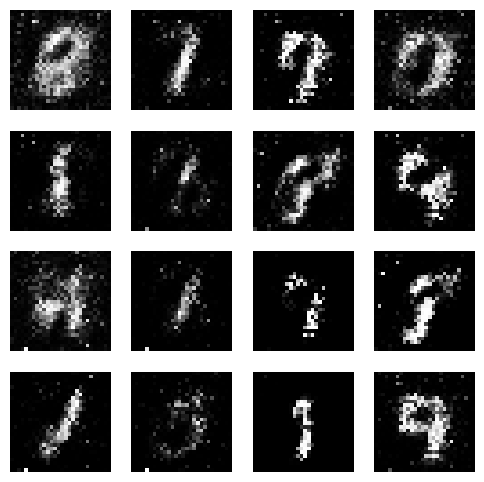

In [102]:
random_noise = torch.randn(16, input_size)
generated_images = generator(random_noise).view(-1, 1, 28, 28).detach()

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()


## 🌼마무리 문제

다양한 데이터셋을 적용해보세요

Q1. Fashion MNIST
- 28X28 크기의 패션 아이템 이미지로 구성된 흑백 이미지 데이터셋


Q2. CIFAR-10
- 32X32 크기의 색상이 있는 자동차, 동물 등 다양한 객체가 포함된 데이터셋